<a href="https://colab.research.google.com/github/Sharame/ModuliDiMachineLearningProgettiUniversitari/blob/main/ML_STATUS_module/notebooks/STATUS_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cella 1: Setup e Caricamento**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

print("="*70)
print("STATUS - FEATURE ENGINEERING")
print("="*70)

# Carica dati
df_users = pd.read_csv('users.csv')
df_logs = pd.read_csv('workoutlogs.csv')
df_workouts = pd.read_csv('workouts.csv')

print("\nDati caricati:")
print(f"  users: {len(df_users)} righe")
print(f"  workout_logs: {len(df_logs)} righe")
print(f"  workouts: {len(df_workouts)} righe")


STATUS - FEATURE ENGINEERING

Dati caricati:
  users: 300 righe
  workout_logs: 171250 righe
  workouts: 52544 righe


**Cella 2: Aggregazione workout_logs per Utente**

In [2]:
print("="*70)
print("AGGREGAZIONE workout_logs per userid")
print("="*70)

# Aggregazione
features_from_logs = df_logs.groupby('userid').agg({
    'loaddonekg': ['mean', 'std', 'max', 'min'],
    'rpedone': ['mean', 'std'],
    'setsdone': 'sum',
    'repsdoneavg': 'mean',
    'repsdonetotal': 'sum',
    'gapadherencescore': ['mean', 'std']
}).reset_index()

# Flatten columns
features_from_logs.columns = ['_'.join(col).strip('_') for col in features_from_logs.columns.values]

# Rinomina
features_from_logs.columns = [
    'userid',
    'load_mean', 'load_std', 'load_max', 'load_min',
    'rpe_mean', 'rpe_std',
    'sets_total',
    'reps_avg',
    'reps_total',
    'gap_mean', 'gap_std'
]

print(f"\nFeature create: {len(features_from_logs.columns) - 1}")
print(f"Utenti: {len(features_from_logs)}")
print("\nPrime 3 righe:")
print(features_from_logs.head(3))


AGGREGAZIONE workout_logs per userid

Feature create: 11
Utenti: 300

Prime 3 righe:
   userid  load_mean   load_std  load_max  load_min  rpe_mean   rpe_std  \
0       1  33.272702   7.179099     51.75     17.25  7.254747  0.512616   
1       2  54.419888  12.567094     91.50     30.50  8.387240  0.567086   
2       3  31.467829   6.992970     48.62     19.25  8.136579  0.510415   

   sets_total  reps_avg  reps_total  gap_mean   gap_std  
0        2168  9.335084       19192  1.005740  0.091665  
1        2146  9.752548       20118  0.959714  0.085924  
2         418  9.954342        4012  0.989954  0.078437  


**Cella 3: Aggregazione workouts per Utente**

In [3]:
print("="*70)
print("AGGREGAZIONE workouts per userid")
print("="*70)

features_from_workouts = df_workouts.groupby('userid').agg({
    'workoutid': 'count',
    'workoutstatus': lambda x: (x == 'done').sum()
}).reset_index()

features_from_workouts.columns = ['userid', 'sessions_total', 'sessions_done']

# Calcola skip rate
features_from_workouts['sessions_skipped'] = (
    features_from_workouts['sessions_total'] - features_from_workouts['sessions_done']
)
features_from_workouts['skip_rate'] = (
    features_from_workouts['sessions_skipped'] / features_from_workouts['sessions_total']
)

print(f"\nFeature create: {len(features_from_workouts.columns) - 1}")
print(f"Utenti: {len(features_from_workouts)}")
print("\nPrime 3 righe:")
print(features_from_workouts.head(3))


AGGREGAZIONE workouts per userid

Feature create: 4
Utenti: 300

Prime 3 righe:
   userid  sessions_total  sessions_done  sessions_skipped  skip_rate
0       1             259            226                33   0.127413
1       2             324            297                27   0.083333
2       3              45             38                 7   0.155556


**Cella 4: Feature Derivate (Coefficiente Variazione)**

In [4]:
print("="*70)
print("FEATURE DERIVATE")
print("="*70)

# Coefficiente di variazione (CV = std/mean)
# Misura consistenza: CV basso = più consistente

features_from_logs['load_cv'] = features_from_logs['load_std'] / features_from_logs['load_mean']
features_from_logs['rpe_cv'] = features_from_logs['rpe_std'] / features_from_logs['rpe_mean']
features_from_logs['gap_cv'] = features_from_logs['gap_std'] / features_from_logs['gap_mean']

# Gestisci divisioni per zero o NaN
features_from_logs = features_from_logs.fillna(0)
features_from_logs = features_from_logs.replace([np.inf, -np.inf], 0)

print("Feature derivate aggiunte:")
print("  - load_cv (coefficiente variazione carico)")
print("  - rpe_cv (coefficiente variazione RPE)")
print("  - gap_cv (coefficiente variazione aderenza)")
print("\nQueste misurano la CONSISTENZA dell'utente")


FEATURE DERIVATE
Feature derivate aggiunte:
  - load_cv (coefficiente variazione carico)
  - rpe_cv (coefficiente variazione RPE)
  - gap_cv (coefficiente variazione aderenza)

Queste misurano la CONSISTENZA dell'utente


**Cella 5: Unione Feature + Target**

In [5]:
print("="*70)
print("UNIONE FEATURE + TARGET")
print("="*70)

# Prendi target da users
df_status = df_users[['userid', 'experience_label']].copy()

# Merge feature da logs
df_status = df_status.merge(features_from_logs, on='userid', how='left')

# Merge feature da workouts
df_status = df_status.merge(features_from_workouts, on='userid', how='left')

# Gestisci NaN (utenti senza dati)
df_status = df_status.fillna(0)

print(f"\nDataset finale:")
print(f"  Righe: {len(df_status)} (1 riga = 1 utente)")
print(f"  Colonne: {len(df_status.columns)}")
print(f"\nTarget: experience_label")
print(f"Feature: {len(df_status.columns) - 2} (esclusi userid e target)")


UNIONE FEATURE + TARGET

Dataset finale:
  Righe: 300 (1 riga = 1 utente)
  Colonne: 20

Target: experience_label
Feature: 18 (esclusi userid e target)


**Cella 6: Verifica Qualità**

In [6]:
print("="*70)
print("VERIFICA QUALITA' DATASET")
print("="*70)

print("\n1. Missing values:")
missing = df_status.isnull().sum().sum()
print(f"   Totale: {missing}")

print("\n2. Distribuzione target:")
target_dist = df_status['experience_label'].value_counts()
print(target_dist)

print("\n3. Feature con varianza zero:")
feature_cols = [col for col in df_status.columns if col not in ['userid', 'experience_label']]
zero_var = [col for col in feature_cols if df_status[col].std() == 0]
if len(zero_var) == 0:
    print("   Nessuna")
else:
    print(f"   {zero_var}")
    print("   (da rimuovere prima del training)")

print("\n4. Range feature principali:")
for col in ['load_mean', 'rpe_mean', 'skip_rate', 'gap_mean']:
    print(f"   {col}: [{df_status[col].min():.2f}, {df_status[col].max():.2f}]")


VERIFICA QUALITA' DATASET

1. Missing values:
   Totale: 0

2. Distribuzione target:
experience_label
Intermediate    171
Beginner        106
Advanced         23
Name: count, dtype: int64

3. Feature con varianza zero:
   Nessuna

4. Range feature principali:
   load_mean: [27.24, 89.45]
   rpe_mean: [6.95, 9.14]
   skip_rate: [0.00, 0.27]
   gap_mean: [0.91, 1.04]


**Cella 7: Salva Dataset**

In [7]:
# Salva
output_file = 'status_features.csv'
df_status.to_csv(output_file, index=False)

print("="*70)
print("DATASET SALVATO")
print("="*70)
print(f"\nFile: {output_file}")
print(f"Righe: {len(df_status)}")
print(f"Colonne: {len(df_status.columns)}")
print(f"\nColonne:")
for i, col in enumerate(df_status.columns, 1):
    print(f"  {i}. {col}")


DATASET SALVATO

File: status_features.csv
Righe: 300
Colonne: 20

Colonne:
  1. userid
  2. experience_label
  3. load_mean
  4. load_std
  5. load_max
  6. load_min
  7. rpe_mean
  8. rpe_std
  9. sets_total
  10. reps_avg
  11. reps_total
  12. gap_mean
  13. gap_std
  14. load_cv
  15. rpe_cv
  16. gap_cv
  17. sessions_total
  18. sessions_done
  19. sessions_skipped
  20. skip_rate


**Cella 8: EDA Post-Engineering - Correlazioni con Target**

EDA POST-ENGINEERING: Correlazioni con Target

Top 10 feature più correlate con target:
gap_mean     0.431
skip_rate    0.162
load_max     0.157
load_min     0.152
rpe_cv       0.139
load_mean    0.137
rpe_mean     0.131
load_std     0.124
gap_cv       0.119
rpe_std      0.094
Name: target_encoded, dtype: float64


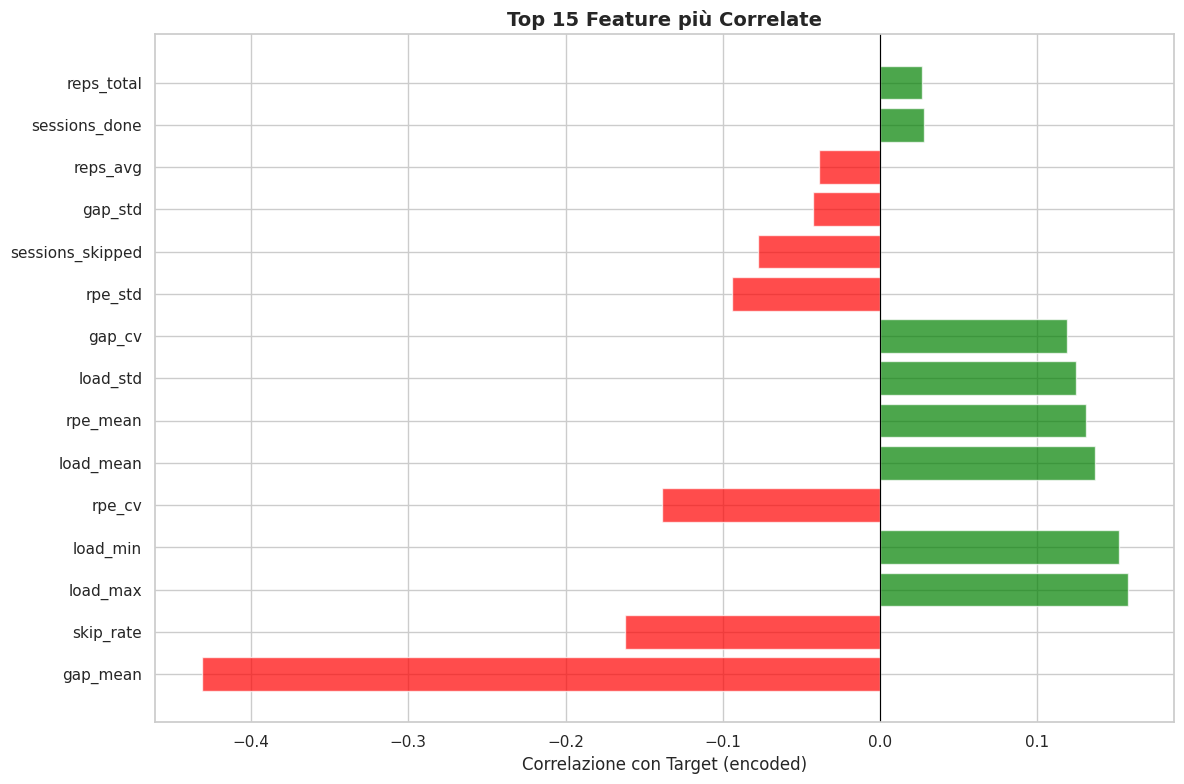

In [8]:
print("="*70)
print("EDA POST-ENGINEERING: Correlazioni con Target")
print("="*70)

# Encode target per correlazione
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_status['target_encoded'] = le.fit_transform(df_status['experience_label'])

# Correlazioni
feature_cols = [col for col in df_status.columns
                if col not in ['userid', 'experience_label', 'target_encoded']]

corr_with_target = df_status[feature_cols + ['target_encoded']].corr()['target_encoded'].drop('target_encoded')
corr_sorted = corr_with_target.abs().sort_values(ascending=False)

print("\nTop 10 feature più correlate con target:")
print(corr_sorted.head(10).round(3))

# Grafico
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
top15 = corr_sorted.head(15)
colors = ['green' if corr_with_target[idx] > 0 else 'red' for idx in top15.index]
ax.barh(range(len(top15)), corr_with_target[top15.index], color=colors, alpha=0.7)
ax.set_yticks(range(len(top15)))
ax.set_yticklabels(top15.index)
ax.set_xlabel('Correlazione con Target (encoded)')
ax.set_title('Top 15 Feature più Correlate', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


**Cella 9: Boxplot Feature per Livello**

/tmp/ipython-input-4156945989.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_status, x='experience_label', y=feat, palette='Set2', ax=axes[i])
/tmp/ipython-input-4156945989.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_status, x='experience_label', y=feat, palette='Set2', ax=axes[i])
/tmp/ipython-input-4156945989.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_status, x='experience_label', y=feat, palette='Set2', ax=axes[i])
/tmp/ipython-input-4156945989.py:8: FutureWarning: 

Passing `palette` without 

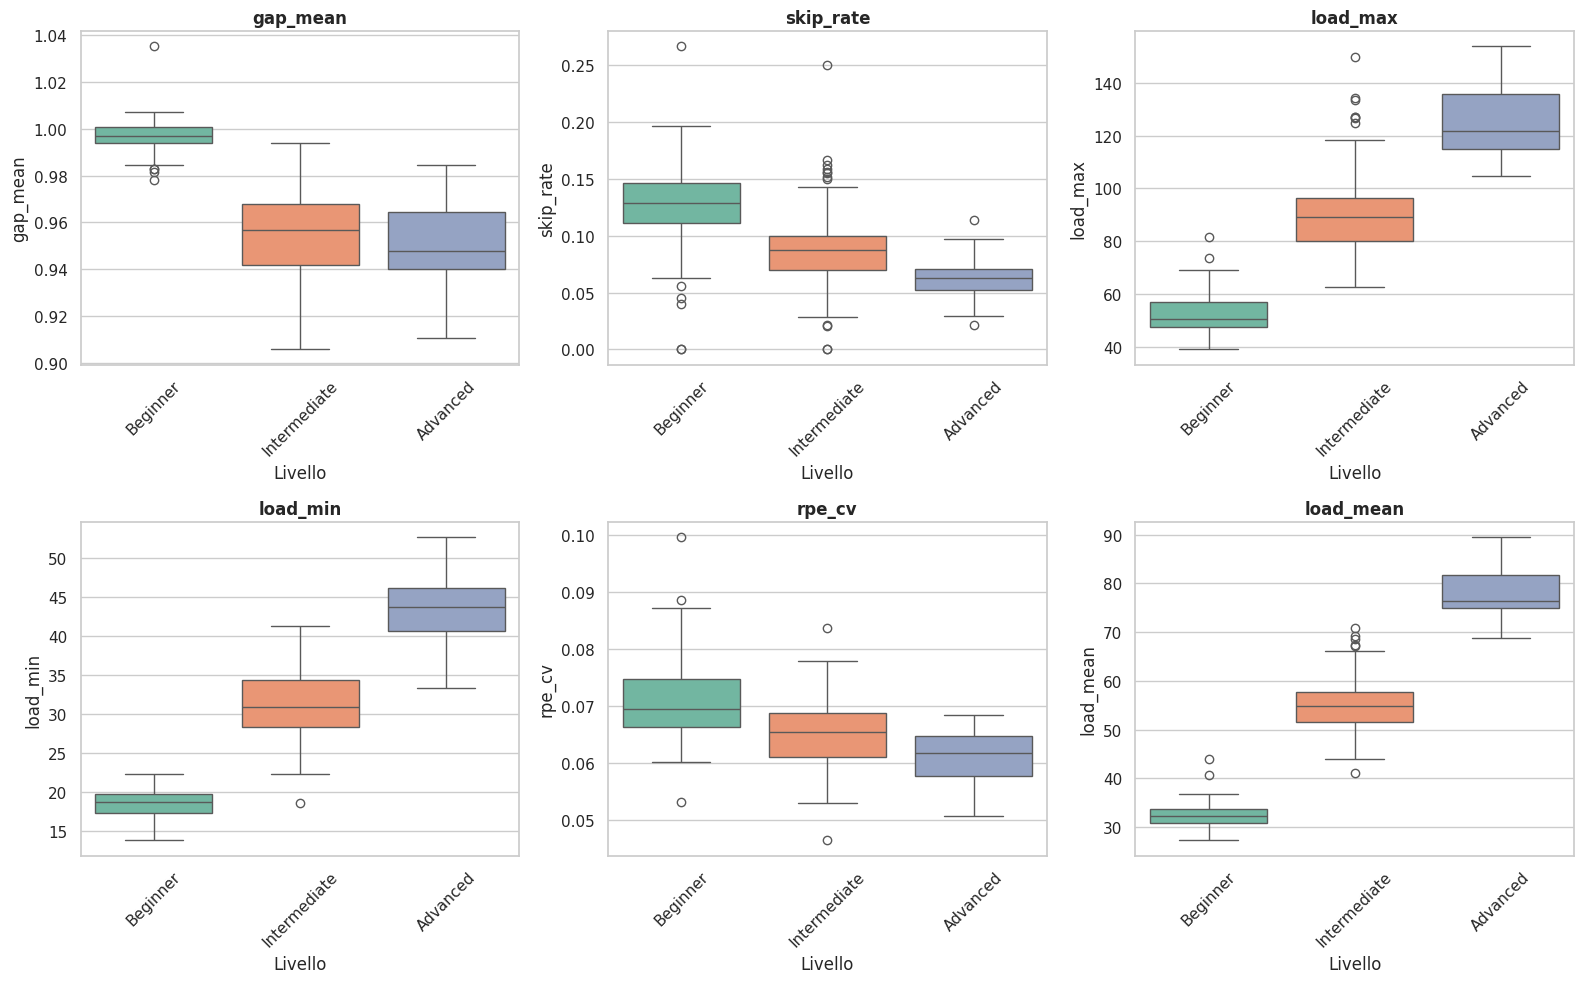

Feature con boxplot ben separati = buone per classificazione


In [9]:
# Visualizza le top 6 feature per livello
top_features = corr_sorted.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, feat in enumerate(top_features):
    sns.boxplot(data=df_status, x='experience_label', y=feat, palette='Set2', ax=axes[i])
    axes[i].set_title(feat, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Livello')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Feature con boxplot ben separati = buone per classificazione")


**Cella 10: Heatmap Correlazioni tra Feature**

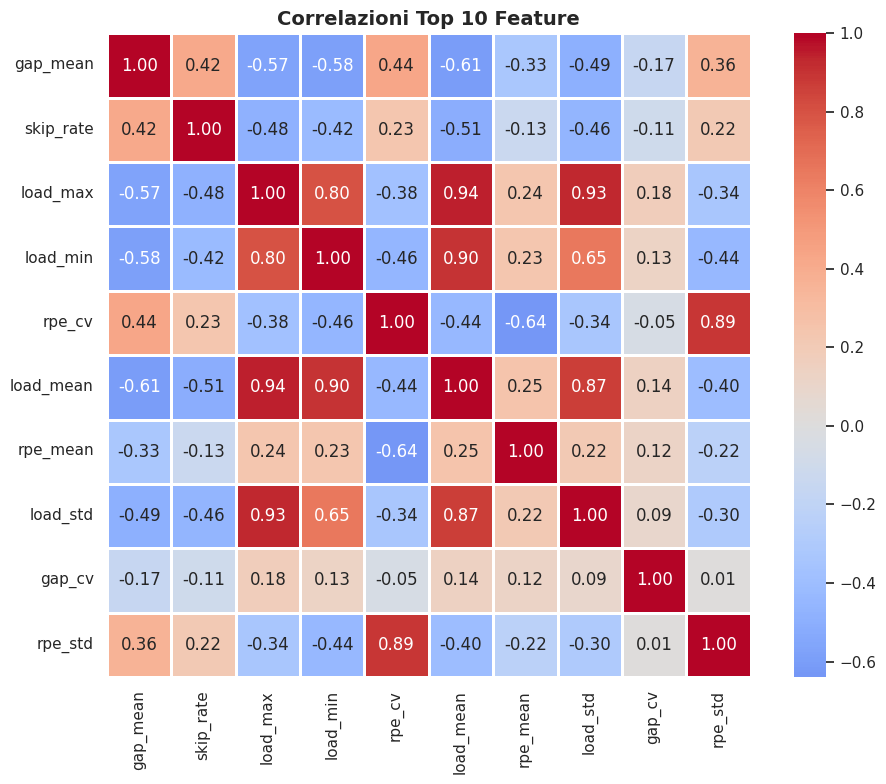

Se due feature sono molto correlate (>0.8), una può essere rimossa


In [10]:
# Correlazioni tra top features
top10 = corr_sorted.head(10).index.tolist()
corr_matrix = df_status[top10].corr()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, ax=ax)
ax.set_title('Correlazioni Top 10 Feature', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Se due feature sono molto correlate (>0.8), una può essere rimossa")


**Cella 11: Summary Feature Engineering**

In [11]:
print("="*70)
print("SUMMARY FEATURE ENGINEERING")
print("="*70)

print("\n1. FEATURE CREATE:")
print(f"   Totale: {len(feature_cols)} feature")
print(f"   Da workout_logs: {len(features_from_logs.columns) - 1}")
print(f"   Da workouts: {len(features_from_workouts.columns) - 1}")
print(f"   Derivate: 3 (CV)")

print("\n2. TOP 5 FEATURE PIU' CORRELATE:")
for i, (feat, corr) in enumerate(corr_sorted.head(5).items(), 1):
    print(f"   {i}. {feat}: {corr:.3f}")

print("\n3. QUALITA':")
print(f"   Missing: {df_status.isnull().sum().sum()}")
print(f"   Feature zero-variance: {len(zero_var)}")

print("\n4. FILE OUTPUT:")
print(f"   {output_file}")
print(f"   {len(df_status)} righe × {len(df_status.columns)} colonne")

print("\n5. PROSSIMO STEP:")
print("   Nuovo notebook: STATUS_Modeling.ipynb")
print("   - Train/test split")
print("   - Model training")
print("   - Evaluation")


SUMMARY FEATURE ENGINEERING

1. FEATURE CREATE:
   Totale: 18 feature
   Da workout_logs: 14
   Da workouts: 4
   Derivate: 3 (CV)

2. TOP 5 FEATURE PIU' CORRELATE:
   1. gap_mean: 0.431
   2. skip_rate: 0.162
   3. load_max: 0.157
   4. load_min: 0.152
   5. rpe_cv: 0.139

3. QUALITA':
   Missing: 0
   Feature zero-variance: 0

4. FILE OUTPUT:
   status_features.csv
   300 righe × 21 colonne

5. PROSSIMO STEP:
   Nuovo notebook: STATUS_Modeling.ipynb
   - Train/test split
   - Model training
   - Evaluation
